# Stanford CME 241 (Winter 2024) - Assignment 7

**Due: Mar 4 @ 11:59pm Pacific Time on Gradescope (after the exam).**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 

-Handi Zhao(hdzhao@stanford.edu);

-Sylvia Sun(ys3835@stanford.edu);

-Zhengji Yang(yangzj@stanford.edu)

## Imports

In [142]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable, Iterator, Mapping, TypeVar, Callable, Sequence, Tuple, Dict
from dataclasses import dataclass, replace, field
from rl.function_approx import Gradient
from rl.function_approx import AdamGradient
from rl.function_approx import LinearFunctionApprox
import rl.markov_process as mp
from rl.markov_decision_process import NonTerminal
from rl.distribution import Choose, Categorical
from rl.markov_process import FiniteMarkovRewardProcess
from itertools import islice, chain
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import extended_vf
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.chapter10.prediction_utils import (
    mc_prediction_learning_rate,
    td_prediction_learning_rate
)
X = TypeVar('X')
S = TypeVar('S')

## Question 1
In the following question, we explore the connection between TD and MC
algorithms.

1.  Implement the TD($\lambda$) Prediction algorithm from scratch in
    Python code. First do it for the Tabular case, then do it for the
    case of Function Approximation.

2.  Prove that the MC Error can be written as the sum of discounted TD
    errors, i.e.,
    $$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
    The goal here is for you to practice formal proof-writing of these
    types of simple yet important identities. So aim to work this out
    from scratch rather than treating this as a special case of a more
    general result proved in class or in the textbook.

3.  Test your above implementation of TD($\lambda$) Prediction algorithm
    by comparing the Value Function of an MRP you have previously
    developed (or worked with) as obtained by Policy Evaluation (DP)
    algorithm, as obtained by MC, as obtained by TD, and as obtained by
    your TD($\lambda$) implementation. Plot graphs of convergence for
    different values of $\lambda$.

4.  Extend `RandomWalkMRP` (in
    [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
    to `RandomWalkMRP2D` which is a random walk in 2-D with states
    $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
    states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
    $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
    for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
    $(i, B_2)$, and with discrete probabilities of 4 movements - UP,
    DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
    convergence of MC and TD on this `RandomWalkMRP2D` much like how we
    analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

### PART I: Tabular TD($\lambda$) and Function Approximation TD($\lambda$) Implementation 

In [89]:
def tabular_td_lambda_predection(
    traces,
    nt_states,
    gamma,
    lambd
):
    values_map = {s: 0.0 for s in nt_states}
    counts_map = {state: 0 for state in nt_states}
    yield values_map

    for trace in traces:
        el_tr = {s: 0.0 for s in nt_states}
        for step in trace:
            x: NonTerminal[S] = step.state
            delta_t: float = step.reward + gamma * values_map[step.next_state] - values_map[x]
            counts_map[x] += 1
            alpha = 1 / (counts_map[x] // 10 + 1)
            for nt_state in nt_states:
                el_tr[nt_state] *= gamma * lambd
            el_tr[x] += 1
            for nt_state in nt_states:
                values_map[nt_state] += alpha * delta_t * el_tr[nt_state]
            yield values_map

In [81]:
def func_approx_td_lambda_predection(
    traces,
    approx_0,
    gamma,
    lambd,
):
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx

    for trace in traces:
        el_tr: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + gamma * extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (gamma * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx

### PART II: Prove MC Error Equality

By definition, we have
$$G_t  = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot R_{u+1}.$$

Note that for terminal state $S_T$, $V(S_T) = 0$. Thus,
\begin{align*}
 \sum_{u=t}^{T-1} \gamma^{u-t} \cdot V(S_u) &= V(S_t) - \gamma^{T-t}\cdot V(S_T) + \sum_{u=t+1}^{T} \gamma^{u-t} \cdot V(S_u)\\
                                            &= V(S_t) + \sum_{u=t}^{T-1} \gamma^{u-t} \cdot \gamma \cdot V(S_{u+1}).
\end{align*}

Hence, 
$$V(S_t) =  \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (V(S_u) - \gamma \cdot V(S_{u+1})).$$

Combining this equation with the expression of $G_t$, we get
$$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$

### PART III: Test TD($\lambda$) Implementations

In [66]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

nt_states: Sequence[NonTerminal[InventoryState]] = si_mrp.non_terminal_states
true_vf: np.ndarray = si_mrp.get_value_function_vec(gamma=gamma)

mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

In [99]:
ffs: Sequence[Callable[[NonTerminal[InventoryState]], float]] = \
    [(lambda x, s=s: float(x.state == s.state)) for s in nt_states]

mc_ag: AdamGradient = AdamGradient(
    learning_rate=0.05,
    decay1=0.9,
    decay2=0.999
)

td_ag: AdamGradient = AdamGradient(
    learning_rate=0.003,
    decay1=0.9,
    decay2=0.999
)

mc_func_approx: LinearFunctionApprox[NonTerminal[InventoryState]] = \
    LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=mc_ag
    )

td_func_approx: LinearFunctionApprox[NonTerminal[InventoryState]] = \
    LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=td_ag
    )

it_mc: Iterable[ValueFunctionApprox[InventoryState]] = \
    mc_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(nt_states),
        gamma=gamma,
        episode_length_tolerance=mc_episode_length_tol,
        initial_func_approx=mc_func_approx
    )

it_td: Iterable[ValueFunctionApprox[InventoryState]] = \
    td_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(nt_states),
        gamma=gamma,
        episode_length=td_episode_length,
        initial_func_approx=td_func_approx
    )

rmse_mc_default = []
mc_episodes: int = 3000
for i, mc_vf in enumerate(islice(it_mc, mc_episodes)):
    mc_rmse: float = np.sqrt(sum(
        (mc_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
    ) / len(nt_states))
    rmse_mc_default.append(mc_rmse)
    if i % 300 == 0:
        print(f"MC: Iteration = {i:d}, RMSE = {mc_rmse:.3f}")

rmse_td_default = []
td_experiences: int = 300000
for i, td_vf in enumerate(islice(it_td, td_experiences)):
    td_rmse: float = np.sqrt(sum(
        (td_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
    ) / len(nt_states))
    rmse_td_default.append(td_rmse)
    if i % 30000 == 0:
        print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")

MC: Iteration = 0, RMSE = 39.307
MC: Iteration = 300, RMSE = 0.618
MC: Iteration = 600, RMSE = 1.529
MC: Iteration = 900, RMSE = 1.841
MC: Iteration = 1200, RMSE = 1.392
MC: Iteration = 1500, RMSE = 0.526
MC: Iteration = 1800, RMSE = 1.058
MC: Iteration = 2100, RMSE = 1.197
MC: Iteration = 2400, RMSE = 0.951
MC: Iteration = 2700, RMSE = 0.764
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 15.060
TD: Iteration = 60000, RMSE = 4.547
TD: Iteration = 90000, RMSE = 1.383
TD: Iteration = 120000, RMSE = 0.446
TD: Iteration = 150000, RMSE = 0.137
TD: Iteration = 180000, RMSE = 0.135
TD: Iteration = 210000, RMSE = 0.124
TD: Iteration = 240000, RMSE = 0.172
TD: Iteration = 270000, RMSE = 0.082


In [100]:
episodes = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
transitions = chain.from_iterable(islice(episode, 100) for episode in episodes)

In [101]:
rmse_tabular_td_lambda = {}
lambd_list = [.1, .3, .5, .7, .9]
for lambd in lambd_list:
    it_tabular_td_lambda = tabular_td_lambda_predection(episodes, nt_states, gamma, lambd)
    print(f"Tabular TD lambda, lambda = {lambd}")
    rmse_tabular_td_lambda_i = []
    for i, td_vf in enumerate(islice(it_tabular_td_lambda, td_experiences)):
        td_rmse: float = np.sqrt(sum(
            (td_vf[s] - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
        ) / len(nt_states))
        rmse_tabular_td_lambda_i.append(td_rmse)
        if i % 30000 == 0:
            print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")
    rmse_tabular_td_lambda[lambd] = rmse_tabular_td_lambda_i

Tabular TD lambda, lambda = 0.1
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 0.163
TD: Iteration = 60000, RMSE = 0.202
TD: Iteration = 90000, RMSE = 0.238
TD: Iteration = 120000, RMSE = 0.221
TD: Iteration = 150000, RMSE = 0.154
TD: Iteration = 180000, RMSE = 0.138
TD: Iteration = 210000, RMSE = 0.091
TD: Iteration = 240000, RMSE = 0.069
TD: Iteration = 270000, RMSE = 0.055
Tabular TD lambda, lambda = 0.3
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 0.402
TD: Iteration = 60000, RMSE = 0.080
TD: Iteration = 90000, RMSE = 0.052
TD: Iteration = 120000, RMSE = 0.101
TD: Iteration = 150000, RMSE = 0.134
TD: Iteration = 180000, RMSE = 0.128
TD: Iteration = 210000, RMSE = 0.121
TD: Iteration = 240000, RMSE = 0.094
TD: Iteration = 270000, RMSE = 0.076
Tabular TD lambda, lambda = 0.5
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 0.103
TD: Iteration = 60000, RMSE = 0.120
TD: Iteration = 90000, RMSE = 0.101
TD: Iteration = 120000, RMSE = 0.104


In [102]:
td_lambda_func_approx: LinearFunctionApprox[NonTerminal[InventoryState]] = \
    LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=td_ag
    )

In [103]:
rmse_func_approx_td_lambda = {}
lambd_list = [.1, .3, .5, .7, .9]
for lambd in lambd_list:
    it_func_approx_td_lambda = func_approx_td_lambda_predection(episodes, td_lambda_func_approx, gamma, lambd)
    print(f"Function approximation TD lambda, lambda = {lambd}")
    rmse_func_approx_td_lambda_i = []
    for i, td_vf in enumerate(islice(it_func_approx_td_lambda, td_experiences)):
        td_rmse: float = np.sqrt(sum(
            (td_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
        ) / len(nt_states))
        rmse_func_approx_td_lambda_i.append(td_rmse)
        if i % 30000 == 0:
            print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")
    rmse_func_approx_td_lambda[lambd] = rmse_func_approx_td_lambda_i

Function approximation TD lambda, lambda = 0.1
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 13.558
TD: Iteration = 60000, RMSE = 3.439
TD: Iteration = 90000, RMSE = 0.812
TD: Iteration = 120000, RMSE = 0.330
TD: Iteration = 150000, RMSE = 0.343
TD: Iteration = 180000, RMSE = 0.125
TD: Iteration = 210000, RMSE = 0.094
TD: Iteration = 240000, RMSE = 0.261
TD: Iteration = 270000, RMSE = 0.202
Function approximation TD lambda, lambda = 0.3
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 11.056
TD: Iteration = 60000, RMSE = 2.447
TD: Iteration = 90000, RMSE = 0.458
TD: Iteration = 120000, RMSE = 0.261
TD: Iteration = 150000, RMSE = 0.230
TD: Iteration = 180000, RMSE = 0.261
TD: Iteration = 210000, RMSE = 0.115
TD: Iteration = 240000, RMSE = 0.164
TD: Iteration = 270000, RMSE = 0.141
Function approximation TD lambda, lambda = 0.5
TD: Iteration = 0, RMSE = 39.307
TD: Iteration = 30000, RMSE = 9.353
TD: Iteration = 60000, RMSE = 1.712
TD: Iteration = 90000, RMS

In [134]:
from matplotlib.colors import LinearSegmentedColormap
blues = ['#1f77b4', '#4c8ed9', '#6ea3e4', '#92b9f2', '#b5d0ff']
cmap = LinearSegmentedColormap.from_list('blues', blues)
colors = ['#1f77b4', '#377eb8', '#4daf4a', '#ff7f0e', '#e41a1c']
cmap = LinearSegmentedColormap.from_list('blue_to_red', colors)

/var/folders/0m/0k8_jpgn7c1bbqkxvrygpktm0000gn/T/ipykernel_54044/755958411.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(0, 1, len(rmse_func_approx_td_lambda)), label='TD(λ) λ values')


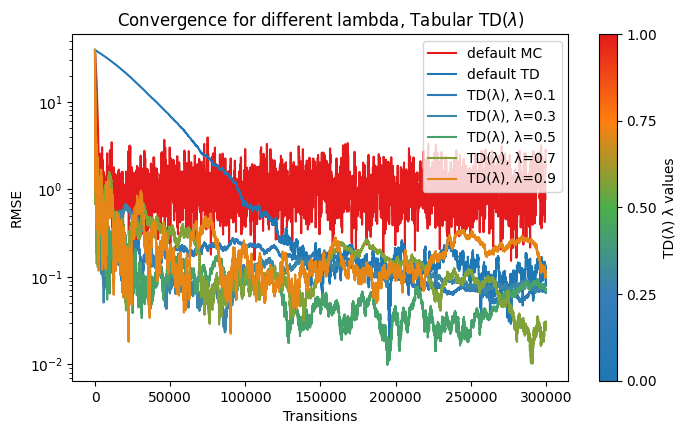

In [138]:
plt.figure(figsize=(8,4.5))
plt.plot([i*100 for i in range(3000)], rmse_mc_default, label='default MC', color=cmap(1.0)) 

plt.plot(rmse_td_default, label='default TD', color=cmap(0)) 

for i, (lambd, rmse_series) in enumerate(rmse_tabular_td_lambda.items()):
    plt.plot(rmse_series, label=f'TD(λ), λ={lambd}', color=cmap((i+1) / (len(rmse_tabular_td_lambda)+2)))

plt.xlabel('Transitions')
plt.ylabel('RMSE')
plt.title('Convergence for different lambda, Tabular TD($\lambda$)')
plt.legend()
plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0, 1, len(rmse_func_approx_td_lambda)), label='TD(λ) λ values')

# Show plot
plt.show()

In [132]:
colors = ['#1f77b4', '#377eb8', '#4daf4a', '#ff7f0e', '#e41a1c']
cmap = LinearSegmentedColormap.from_list('blue_to_red', colors)

/var/folders/0m/0k8_jpgn7c1bbqkxvrygpktm0000gn/T/ipykernel_54044/214437132.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(0, 1, len(rmse_func_approx_td_lambda)), label='TD(λ) λ values')


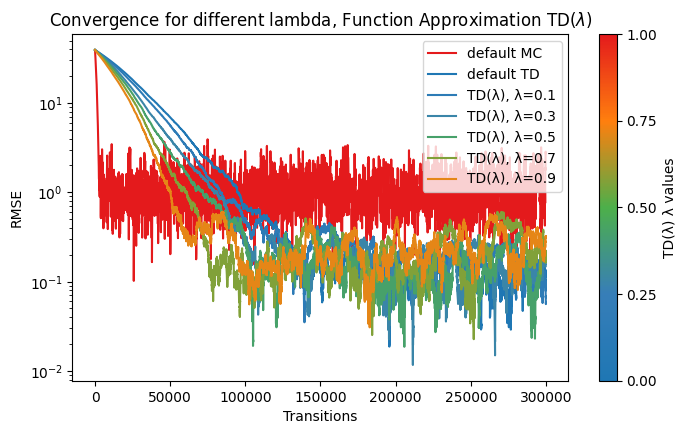

In [139]:
plt.figure(figsize=(8,4.5))

plt.plot([i*100 for i in range(3000)], rmse_mc_default, label='default MC', color=cmap(1.0)) 

plt.plot(rmse_td_default, label='default TD', color=cmap(0)) 

for i, (lambd, rmse_series) in enumerate(rmse_func_approx_td_lambda.items()):
    plt.plot(rmse_series, label=f'TD(λ), λ={lambd}', color=cmap((i+1) / (len(rmse_func_approx_td_lambda)+2)))

plt.xlabel('Transitions')
plt.ylabel('RMSE')
plt.title('Convergence for different lambda, Function Approximation TD($\lambda$)')
plt.legend()
plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0, 1, len(rmse_func_approx_td_lambda)), label='TD(λ) λ values')

# Show plot
plt.show()

In [144]:
class RandomWalkMRP2D(FiniteMarkovRewardProcess[int]):
    barrier: Tuple[int]
    p: Tuple[float]

    def __init__(
        self,
        barrier: Tuple[int],
        p: Tuple[float]
    ):
        self.barrier = barrier
        self.p = p
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int], Categorical[Tuple[Tuple[int], float]]]:
        d: Dict[Tuple[int], Categorical[Tuple[Tuple[int], float]]] = {
            (i, j): Categorical({
                ((i + 1, j), 1. if i+1 == self.barrier[0] else 0.): self.p[0],
                ((i - 1, j), 0.): self.p[1],
                ((i, j + 1), 1. if j+1 == self.barrier[1] else 0.): self.p[2],
                ((i, j - 1), 0.): self.p[3],
            }) for i in range(1, self.barrier[0])
            for j in range(1, self.barrier[1])
        }
        return d

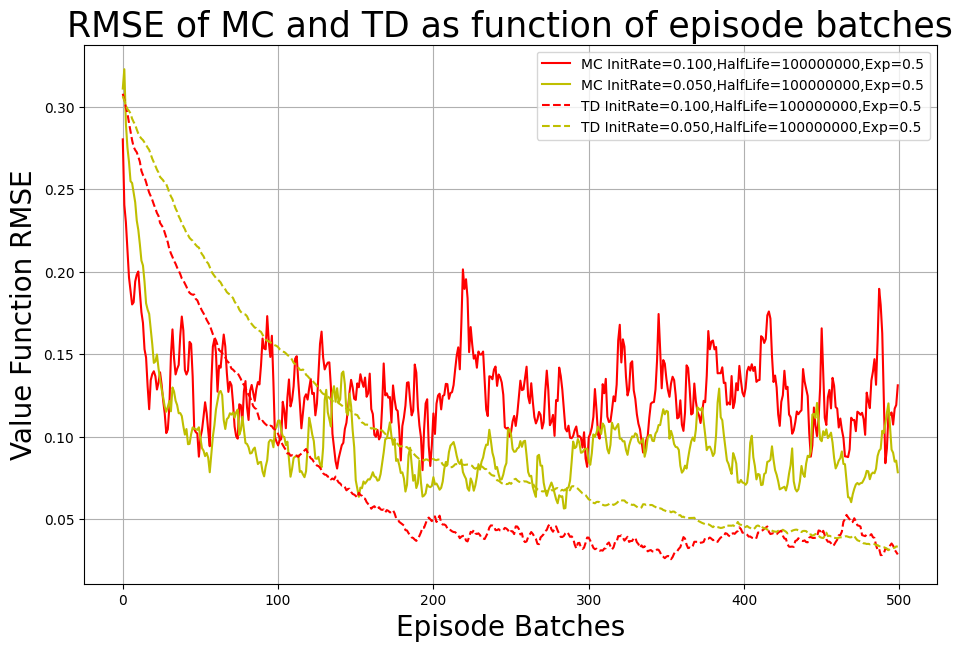

In [175]:
from rl.chapter10.prediction_utils import compare_td_and_mc

this_barrier: Tuple[int] = (10, 10)
this_p: Tuple[float] = (0.2, 0.3, 0.25, 0.25)
random_walk: RandomWalkMRP2D = RandomWalkMRP2D(
    barrier=this_barrier,
    p=this_p
)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=3500,
    learning_rates=[(.1, 1e8, .5), (.05, 1e8, .5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)

## Question 2
In this question, we will explore three different algorithms for control
based on MC or TD. Please complete 2 of the following 3 implementations.
For each algorithm, we expect you to test your implementation against
the Optimal Value Function/Optimal Policy obtained by DP on
`SimpleInventoryMDPCap` in
[rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py).
Then, generalize to MC Control with Function approximation and test your
implementation against the Optimal Value Function/Optimal Policy
obtained by ADP on `AssetAllocDiscrete` in
[rl/chapter7/asset_alloc_discrete.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter7/asset_alloc_discrete.py).

1.  Implement Tabular Monte-Carlo Control algorithm in Python with GLIE
    implemented as $\epsilon = \frac 1 k$ for episode number $k$ and
    initial state of each episode sampled uniformly from the state
    space.

2.  Implement Tabular SARSA algorithm in Python with GLIE and a
    parameterized trajectory of decreasing step sizes.

3.  Implement Tabular Q-Learning algorithm in Python with infinite
    exploration of all (state, action) pairs and with a parameterized
    trajectory of decreasing step sizes.

## Question 3
Finally, we will explore reinforcment learning algorithms and apply them
to the problem of Amercian options pricing. Implement the following two
algorithms and apply them to the problem of American Options Pricing, as
covered in class. Test by comparing the pricing of American Calls and
Puts against the Binomial Tree implmeentation in
[rl/chapter8/optimal_exercise_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py).

1.  LSPI

2.  Deep Q-Learning